In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
sns.set(rc={'figure.figsize':(10,5)})


In [2]:
df = pd.read_csv('attribution data.csv')
df = df.sort_values(['cookie','time'],ascending=[False,True])

In [3]:
df['visit_order']  = df.groupby('cookie').cumcount() + 1 

In [4]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2


In [5]:
#df_paths = df.groupby('cookie')['channel'].aggregate(
    #lambda x: x.unique().tolist()).reset_index()
    
df_paths = df.groupby('cookie')['channel'].apply(lambda x: x.tolist()).reset_index()
    
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

In [6]:
df_paths['path'] = np.where(
 df_paths['conversion'] == 0,
 ['Start, '] + df_paths['channel'].apply(', '.join) + [', Null'],
 ['Start, '] + df_paths['channel'].apply(', '.join) + [', Conversion'])
df_paths['path'] = df_paths['path'].str.split(', ')

### define function that identifies all potential state transitions and outputs a dictionary containing these. 
#### We’ll use this as an input when calculating transition probabilities

In [7]:
list_of_paths = df_paths['path'] 

In [8]:
total_conversions = df['conversion'].sum()
total_conversions

17639

In [9]:
base_conversion_rate = total_conversions/len(list_of_paths)
print('Base conversion rate : ', round(base_conversion_rate*100,2))

Base conversion rate :  7.35


In [10]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    print('List of unique channels : ', list_of_unique_channels)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
   

    for possible_state in list_of_unique_channels:
         
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                
                if possible_state in user_path:
                    
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                   
                    for col in indices:
                        
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1
                        
                        
                        
                     

    return transition_states


trans_states = transition_states(list_of_paths)

List of unique channels :  {'Instagram', 'Null', 'Online Display', 'Online Video', 'Start', 'Paid Search', 'Conversion', 'Facebook'}


### function to calculate all transition probabilities 

In [11]:
list_of_unique_channels = set(x for element in list_of_paths for x in element)
trans_prob = defaultdict(dict)


trans_dict = trans_states

for state in list_of_unique_channels:
    if state not in ['Conversion','Null']:
        
        counter = 0
        index = [i for i,s in enumerate(trans_dict) if state + '>' in s]
        for col in index:
            if trans_dict[list(trans_dict)[col]] > 0:
                counter += trans_dict[list(trans_dict)[col]]
                
        for col in index:
            if trans_dict[list(trans_dict)[col]] > 0:
                state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                trans_prob[list(trans_dict)[col]] = state_prob
                    


In [12]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    
    
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            
            
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
           
            for col in index:
                
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
                    
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob

#dictionary containing all transitions and their respective transition probabilities given historical data.
trans_prob = transition_prob(trans_states)

###  removal effects for each of our marketing channels.

In [13]:
# turn above transition probabilities dictionary into a data frame (matrix):

In [14]:
def transition_matrix(list_of_paths,transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    
    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion','Null'] else 0.0
        
    for key,value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value
    return trans_matrix
trans_matrix = transition_matrix(list_of_paths,trans_prob)

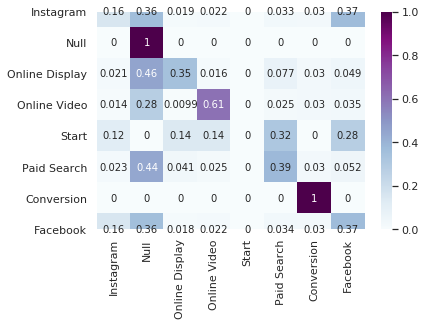

In [15]:
sns.heatmap(trans_matrix,cmap='BuPu',annot = True)
plt.show()

In [16]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [17]:

def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)
 

In [18]:
att = pd.DataFrame.from_dict(attributions,orient = 'index').rename(columns = {0:'channel'}) 

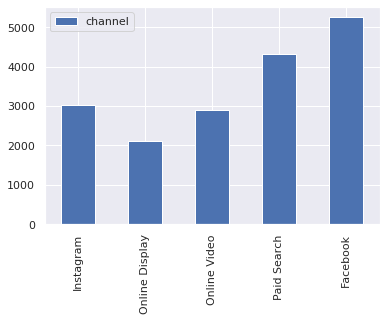

In [19]:
att.plot(kind = 'bar')

In [20]:
sum(list(attributions.values()) )

17639.0

In [21]:
df['conversion'].value_counts()

0    569098
1     17639
Name: conversion, dtype: int64

In [22]:
before_att = round((df.groupby('channel')['conversion'].sum()/df.groupby('channel')['conversion'].sum().sum())*100,2)
before_att.sort_values(ascending=False)

channel
Facebook          30.05
Paid Search       25.78
Online Video      19.32
Instagram         12.72
Online Display    12.13
Name: conversion, dtype: float64

In [23]:
att = round((att/att['channel'].sum())*100,2)
att.sort_values(by = 'channel',ascending = False)

,channel
Facebook,29.78
Paid Search,24.56
Instagram,17.14
Online Video,16.51
Online Display,12.01
